In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#for i in range(1,7):
#    m4a_file = 'AcousticKeylogger/archive/fold11/m4a/f_q_'+str(i)+'.m4a'
#    wav_filename = r"AcousticKeylogger/archive/fold11/f_q_"+str(i)+".wav"
#    from pydub import AudioSegment
#    track = AudioSegment.from_file(m4a_file,  format= 'm4a')
#    file_handle = track.export(wav_filename, format='wav')

/var/folders/jn/5psmqwm90nbd0f2dhg14h83c0000gn/T/ipykernel_36391/2711655728.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  sound_info = pylab.fromstring(frames, 'int16')


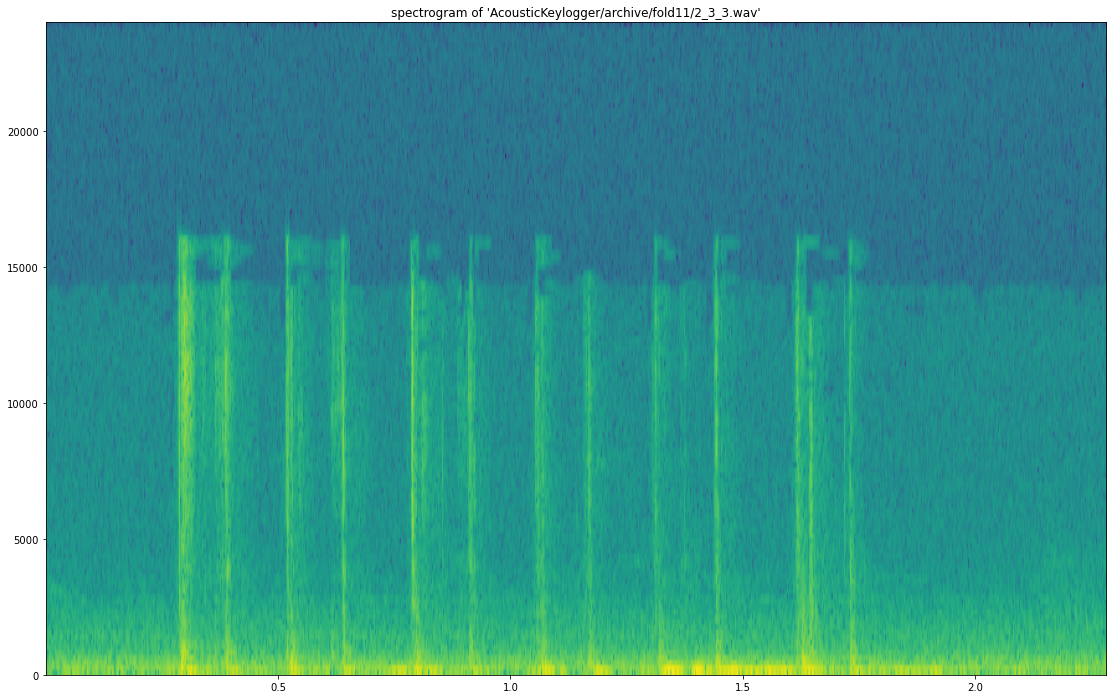

In [3]:
import os
import wave

import pylab
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig('spectrogram.png')
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
graph_spectrogram('AcousticKeylogger/archive/fold11/2_3_3.wav')

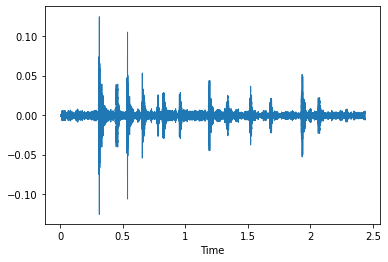

In [4]:
file_name='AcousticKeylogger/archive/fold11/1_1_1.wav'

audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveshow(audio_data,sr=sampling_rate)
ipd.Audio(file_name)


In [5]:
print(audio_data)

[-9.6354154e-07  2.3532195e-06 -1.2715646e-05 ...  2.9183198e-03
  3.1890552e-03  0.0000000e+00]


In [6]:
audio_dataset_path='AcousticKeylogger/archive/'
metadata=pd.read_csv('AcousticKeylogger/archive/keylogger.csv')
metadata.head()

,slice_file_name,fold,classID,class
0,3_2_4.wav,11,2,password
1,2_3_5.wav,11,3,qwerty
2,1_1_5.wav,11,1,123456
3,3_2_5.wav,11,2,password
4,2_1_3.wav,11,1,123456


In [7]:
metadata['class'].value_counts()

password    31
qwerty      30
123456      29
Name: class, dtype: int64

In [8]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=44100, n_mfcc=13)


In [9]:
mfccs

array([[-6.4753448e+02, -5.7767169e+02, -5.6491254e+02, ...,
        -5.7079517e+02, -5.6777478e+02, -5.5024298e+02],
       [ 1.7610281e+02,  1.8943425e+02,  1.8895612e+02, ...,
         1.8169136e+02,  1.8208041e+02,  1.7049174e+02],
       [ 1.9061943e+01,  7.1172481e+00,  1.6777451e+00, ...,
        -5.6810341e+00, -5.9510279e+00,  2.6101708e+00],
       ...,
       [-1.6930920e+01, -5.7530622e+00,  6.2001806e-01, ...,
        -3.1953061e+00,  1.5604863e+00,  4.6141405e+00],
       [-5.3450398e+00, -2.0348725e+00, -3.9171827e-01, ...,
         3.2103622e+00,  2.3981321e+00,  3.4373217e+00],
       [ 8.8248501e+00,  5.5818424e+00,  2.0102034e+00, ...,
         3.1337266e+00,  8.7077188e-01,  3.9703815e+00]], dtype=float32)

In [10]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [11]:
from tqdm import tqdm
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

90it [00:03, 26.84it/s]


In [12]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head(100)

,feature,class
0,"[-497.62485, 144.43028, 24.586874, 19.014421, ...",password
1,"[-509.95822, 148.14186, 23.229092, 21.144806, ...",qwerty
2,"[-496.63104, 144.97252, 18.503483, 24.03396, 1...",123456
3,"[-499.55798, 150.09415, 23.272343, 19.922903, ...",password
4,"[-493.8755, 144.19331, 22.638514, 20.130417, 1...",123456
...,...,...
85,"[-467.3026, 103.26936, 43.59936, 37.18757, 11....",123456
86,"[-470.99362, 109.21382, 42.183765, 35.695065, ...",123456
87,"[-448.92075, 110.0631, 41.271698, 35.826912, 1...",123456
88,"[-450.34097, 103.519, 39.398987, 32.027637, 14...",password


In [13]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape

(90, 40)

In [15]:
y.shape

(90,)

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [17]:
y

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0

In [18]:
y.shape

(90, 3)

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [20]:
import tensorflow as tf
print(tf.__version__)

2.4.0-rc0


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [22]:
num_labels = y.shape[1]
num_labels

3

In [135]:
model=Sequential()

#Input
model.add(Dense(40,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#Layer 1
model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#Layer 2
model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(0.2))

#Output 
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [136]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 40)                1640      
_________________________________________________________________
activation_12 (Activation)   (None, 40)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 80)                3280      
_________________________________________________________________
activation_13 (Activation)   (None, 80)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 80)               

In [137]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [175]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1, shuffle=True)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
3/3 [==============================] - 0s 19ms/step - loss: 0.3720 - accuracy: 0.8472 - val_loss: 0.3605 - val_accuracy: 0.7222

Epoch 00001: val_loss improved from inf to 0.36052, saving model to saved_models/audio_classification.hdf5
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.8750 - val_loss: 0.2882 - val_accuracy: 0.9444

Epoch 00002: val_loss improved from 0.36052 to 0.28825, saving model to saved_models/audio_classification.hdf5
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 0.5628 - accuracy: 0.7778 - val_loss: 0.3065 - val_accuracy: 0.8889

Epoch 00003: val_loss did not improve from 0.28825
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.4771 - accuracy: 0.8472 - val_loss: 0.3271 - val_accuracy: 0.8889

Epoch 00004: val_loss did not improve from 0.28825
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 0.4041 - accuracy: 0.8194 - val_loss: 0.3570 - v

3/3 [==============================] - 0s 7ms/step - loss: 0.5119 - accuracy: 0.7778 - val_loss: 0.3887 - val_accuracy: 0.8333

Epoch 00043: val_loss did not improve from 0.28825
Epoch 44/100
3/3 [==============================] - 0s 7ms/step - loss: 0.5748 - accuracy: 0.7361 - val_loss: 0.5300 - val_accuracy: 0.7222

Epoch 00044: val_loss did not improve from 0.28825
Epoch 45/100
3/3 [==============================] - 0s 8ms/step - loss: 0.4044 - accuracy: 0.7778 - val_loss: 0.4705 - val_accuracy: 0.7778

Epoch 00045: val_loss did not improve from 0.28825
Epoch 46/100
3/3 [==============================] - 0s 7ms/step - loss: 0.5453 - accuracy: 0.7500 - val_loss: 0.3090 - val_accuracy: 0.9444

Epoch 00046: val_loss did not improve from 0.28825
Epoch 47/100
3/3 [==============================] - 0s 7ms/step - loss: 0.4286 - accuracy: 0.8472 - val_loss: 0.3190 - val_accuracy: 0.8889

Epoch 00047: val_loss did not improve from 0.28825
Epoch 48/100
3/3 [==============================] - 0

3/3 [==============================] - 0s 7ms/step - loss: 0.5265 - accuracy: 0.7361 - val_loss: 0.3487 - val_accuracy: 0.8889

Epoch 00085: val_loss did not improve from 0.25450
Epoch 86/100
3/3 [==============================] - 0s 7ms/step - loss: 0.5918 - accuracy: 0.6389 - val_loss: 0.3579 - val_accuracy: 0.8889

Epoch 00086: val_loss did not improve from 0.25450
Epoch 87/100
3/3 [==============================] - 0s 7ms/step - loss: 0.4652 - accuracy: 0.8056 - val_loss: 0.3949 - val_accuracy: 0.9444

Epoch 00087: val_loss did not improve from 0.25450
Epoch 88/100
3/3 [==============================] - 0s 7ms/step - loss: 0.4850 - accuracy: 0.7361 - val_loss: 0.5026 - val_accuracy: 0.9444

Epoch 00088: val_loss did not improve from 0.25450
Epoch 89/100
3/3 [==============================] - 0s 7ms/step - loss: 0.5390 - accuracy: 0.7361 - val_loss: 0.5105 - val_accuracy: 0.9444

Epoch 00089: val_loss did not improve from 0.25450
Epoch 90/100
3/3 [==============================] - 0

In [176]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9444444179534912


In [180]:
filename="AcousticKeylogger/archive/fold11/test_password.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)
#predicted_label=model.predict_classes(mfccs_scaled_features)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[1]


array(['password'], dtype='<U8')

In [181]:
filename="AcousticKeylogger/archive/fold11/test_qwerty.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)
#predicted_label=model.predict_classes(mfccs_scaled_features)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[2]


array(['qwerty'], dtype='<U8')

In [182]:
filename="AcousticKeylogger/archive/fold11/test_123456.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

#print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)
#predicted_label=model.predict_classes(mfccs_scaled_features)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[0]


array(['123456'], dtype='<U8')